In [1]:
!pip -q install kaggle
!mkdir ~/.kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d julian3833/reef-cv-strategy-subsequences-dataframes
!kaggle competitions download tensorflow-great-barrier-reef

In [ ]:
!unzip -qq /content/reef-cv-strategy-subsequences-dataframes.zip
!unzip -qq /content/tensorflow-great-barrier-reef.zip

In [2]:
!ls -alh

total 12K
drwxr-xr-x 3 root root 4.0K Jul  4 07:39 .
drwxr-xr-x 5 root root 4.0K Jul  4 07:39 ..
drwxr-xr-x 2 root root 4.0K Jul  4 07:39 .virtual_documents


# Clone Repo of DERT

In [3]:
!git clone https://github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265
Receiving objects: 100% (265/265), 21.19 MiB | 35.22 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [4]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import sys
sys.path.append('./detr/')
import time
import random
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion


import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=42)

# Configuration

In [5]:
NUM_CLASSES = 2
NUM_QUERIES = 30
NULL_CLASS_COEF = 0.1
BATCH_SIZE = 10
LR = 2e-5
EPOCHS = 10

WIDTH = 1280
HEIGHT = 720

BASE_DIR = "/kaggle/input/tensorflow-great-barrier-reef/train_images/"

# Train-validation split

In [6]:
df = pd.read_csv("/kaggle/input/reef-cv-strategy-subsequences-dataframes/train-validation-split/train-0.1.csv")

# Turn annotations from strings into lists of dictionaries
df['annotations'] = df['annotations'].apply(eval)

# Create the image path for the row
df['image_path'] = "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

df.head()

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     40258            0               0      0-0          []   
1         0     40258            1               1      0-1          []   
2         0     40258            2               2      0-2          []   
3         0     40258            3               3      0-3          []   
4         0     40258            4               4      0-4          []   

   n_annotations  has_annotations     image_path  subsequence_id  is_train  
0              0            False  video_0/0.jpg               1      True  
1              0            False  video_0/1.jpg               1      True  
2              0            False  video_0/2.jpg               1      True  
3              0            False  video_0/3.jpg               1      True  
4              0            False  video_0/4.jpg               1      True

In [7]:
def clean_annotations(annotations):
    new_annotations = []
    for a in annotations:
        x_max = a['x'] + a['width']
        y_max = a['y'] + a['height']
        if x_max > WIDTH or y_max > HEIGHT:
            print("Found broken annotation:", a, x_max, y_max)
        else:
            new_annotations.append(a)
    return new_annotations

In [8]:
# Drop annotation exceeding the image frame
# We could clip them also. Smarter and possibly better?
df['annotations'] = df['annotations'].apply(clean_annotations)

Found broken annotation: {'x': 890, 'y': 687, 'width': 28, 'height': 34} 918 721
Found broken annotation: {'x': 894, 'y': 694, 'width': 28, 'height': 33} 922 727
Found broken annotation: {'x': 286, 'y': 704, 'width': 85, 'height': 35} 371 739
Found broken annotation: {'x': 932, 'y': 698, 'width': 32, 'height': 36} 964 734
Found broken annotation: {'x': 1222, 'y': 395, 'width': 70, 'height': 57} 1292 452
Found broken annotation: {'x': 559, 'y': 686, 'width': 48, 'height': 35} 607 721
Found broken annotation: {'x': 693, 'y': 638, 'width': 74, 'height': 83} 767 721
Found broken annotation: {'x': 374, 'y': 671, 'width': 59, 'height': 50} 433 721
Found broken annotation: {'x': 315, 'y': 670, 'width': 66, 'height': 51} 381 721
Found broken annotation: {'x': 640, 'y': 674, 'width': 76, 'height': 68} 716 742
Found broken annotation: {'x': 526, 'y': 659, 'width': 82, 'height': 64} 608 723
Found broken annotation: {'x': 526, 'y': 675, 'width': 81, 'height': 64} 607 739
Found broken annotation: {

In [9]:
# Drop images with no annotations. The background works as negative samples anyway
df = df[df.annotations.str.len() > 0 ].reset_index(drop=True)

In [10]:
# Train-validation split
df_train, df_val = df[df['is_train']], df[~df['is_train']]

# Augmentations

In [11]:
import torchvision.transforms as T

In [12]:
def get_train_transform():
    return A.Compose([
        #A.Flip(0.5),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(p=1.0),

    ])#, bbox_params={'format': 'coco', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ToTensorV2(p=1.0),

    ])#, bbox_params={'format': 'coco', 'label_fields': ['labels']})

# Creating Dataset

In [13]:
class ReefDataset(Dataset):

    def __init__(self, df, transforms):
        self.df = df
        self.transforms = transforms

    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_center, y_center, w, h]"""
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height'])
        boxes['x'] = boxes['x'] + (boxes['width'] / 2)
        boxes['y'] = boxes['y'] + (boxes['height'] / 2)

        return boxes.astype(float).values

    def get_image(self, row):
        """Gets the image for a given row"""

        image = cv2.imread(f'{BASE_DIR}/{row["image_path"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        return image

    def plot_img(self, i):
        img, _, _ = self[i]
        plt.imshow(img.permute(1, 2, 0))
        plt.show()

    def __getitem__(self, i):

        row = self.df.iloc[i]
        image = self.get_image(row)
        boxes = self.get_boxes(row)

        n_boxes = boxes.shape[0]


        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'image_id': torch.tensor([i]),

            # There is only one class
            'labels': torch.zeros((n_boxes,), dtype=torch.int64),
        }

        image_id = self.df.iloc[i]['image_path']

        sample = {
            'image': image,
            'bboxes': target['boxes'],
            'labels': target['labels']
        }
        image = self.transforms(image=sample['image'])['image']

        target['boxes'] = target['boxes'] / torch.tensor([WIDTH, HEIGHT, WIDTH, HEIGHT], dtype=torch.float32)
        target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)

        return image, target, image_id

    def __len__(self):
        return len(self.df)


# Create Datasets and DataLoaders

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

ds_train = ReefDataset(df_train, get_train_transform())
ds_val = ReefDataset(df_val, get_valid_transform())

dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE,
                      shuffle=True, num_workers=4, collate_fn=collate_fn)


dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,
                    num_workers=4, collate_fn=collate_fn)

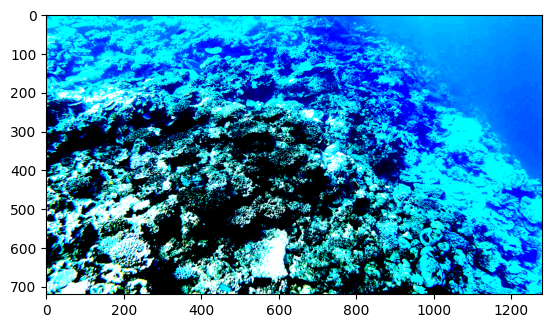

In [15]:
ds_train.plot_img(0)

# Model

In [16]:
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,images):
        return self.model(images)

# Utils

In [17]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Matcher and Bipartite Matching Loss

In [18]:
matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

# Training Function

In [19]:
def train_fn(data_loader, model, criterion, optimizer, device, scheduler, epoch):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, targets, image_ids) in enumerate(tk0):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        output = model(images)
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss

# Eval Function

In [20]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)

            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)

    return summary_loss

# Training/validation loop

In [22]:
device = torch.device('cuda')
model = DETRModel(num_classes=NUM_CLASSES, num_queries=NUM_QUERIES)
model = model.to(device)
criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses)
criterion = criterion.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

best_loss = 10**5
for epoch in range(EPOCHS):
    time_start = time.time()
    train_loss = train_fn(dl_train, model, criterion, optimizer,device,scheduler=None,epoch=epoch)
    valid_loss = eval_fn(dl_val, model,criterion, device)

    elapsed = time.time() - time_start
    chk_name = f'pytorch_model_e{epoch}.bin'
    torch.save(model.state_dict(), chk_name)
    print(f"[Epoch {epoch+1:2d} / {EPOCHS:2d}] Train loss: {train_loss.avg:.3f}. Val loss: {valid_loss.avg:.3f} --> {chk_name}  [{elapsed/60:.0f} mins]")

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        print(f'Best model found in epoch {epoch+1}........Saving Model')
        torch.save(model.state_dict(), 'pytorch_model.bin')

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
100%|██████████| 53/53 [00:43<00:00,  1.22it/s, loss=1.56]


[Epoch  1 / 10] Train loss: 1.586. Val loss: 1.560 --> pytorch_model_e0.bin  [15 mins]
Best model found in epoch 1........Saving Model


100%|██████████| 53/53 [00:41<00:00,  1.27it/s, loss=1.45]


[Epoch  2 / 10] Train loss: 1.548. Val loss: 1.446 --> pytorch_model_e1.bin  [14 mins]
Best model found in epoch 2........Saving Model


100%|██████████| 53/53 [00:41<00:00,  1.27it/s, loss=1.54]


[Epoch  3 / 10] Train loss: 1.465. Val loss: 1.541 --> pytorch_model_e2.bin  [14 mins]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s, loss=1.46]


[Epoch  4 / 10] Train loss: 1.482. Val loss: 1.462 --> pytorch_model_e3.bin  [14 mins]


100%|██████████| 53/53 [00:41<00:00,  1.26it/s, loss=1.42]


[Epoch  5 / 10] Train loss: 1.416. Val loss: 1.420 --> pytorch_model_e4.bin  [14 mins]
Best model found in epoch 5........Saving Model


100%|██████████| 53/53 [00:41<00:00,  1.27it/s, loss=1.48]


[Epoch  6 / 10] Train loss: 1.323. Val loss: 1.484 --> pytorch_model_e5.bin  [14 mins]


100%|██████████| 53/53 [00:41<00:00,  1.26it/s, loss=1.6] 


[Epoch  7 / 10] Train loss: 1.347. Val loss: 1.596 --> pytorch_model_e6.bin  [14 mins]


100%|██████████| 53/53 [00:41<00:00,  1.27it/s, loss=1.23] 


[Epoch  8 / 10] Train loss: 1.177. Val loss: 1.233 --> pytorch_model_e7.bin  [14 mins]
Best model found in epoch 8........Saving Model


100%|██████████| 53/53 [00:41<00:00,  1.27it/s, loss=1.17] 


[Epoch  9 / 10] Train loss: 1.025. Val loss: 1.168 --> pytorch_model_e8.bin  [14 mins]
Best model found in epoch 9........Saving Model


100%|██████████| 53/53 [00:41<00:00,  1.27it/s, loss=1.21] 


[Epoch 10 / 10] Train loss: 1.135. Val loss: 1.214 --> pytorch_model_e9.bin  [14 mins]


# Sample

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


[0.6056693, 0.4828305, 0.45030025, 0.43260756, 0.34928453, 0.34722483, 0.27344194, 0.25027, 0.22602889, 0.1902177]


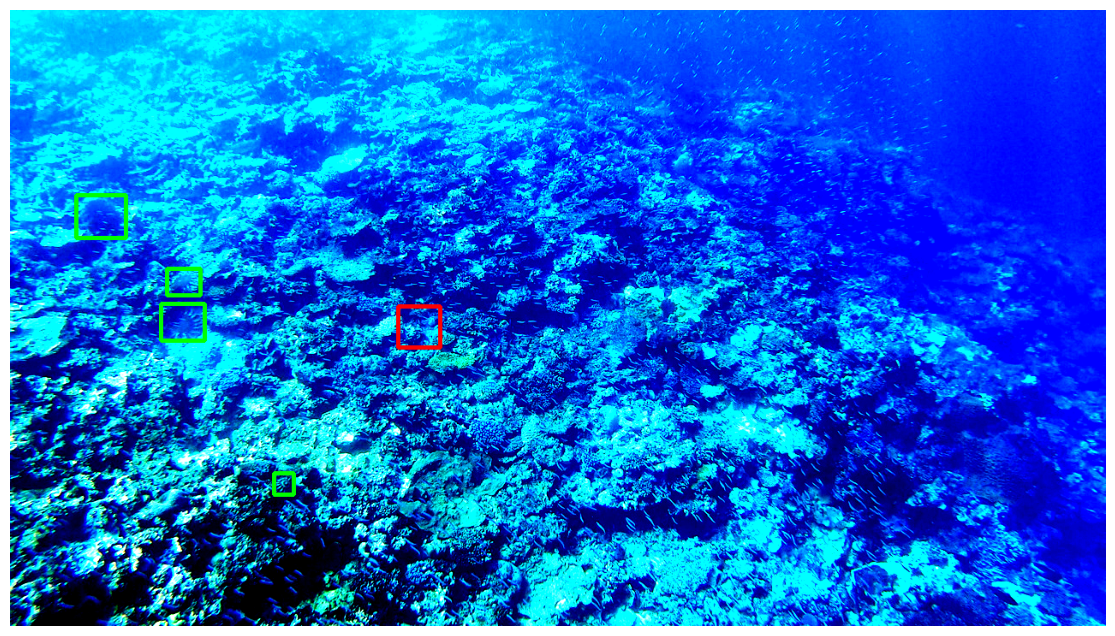

In [23]:
def view_sample(df_sample, model, device):
    ds_val = ReefDataset(df_sample, get_valid_transform())
    dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, collate_fn=collate_fn)

    images, targets, image_ids = next(iter(dl_val))

    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # [x_center, y_center, width, height] # All scaled
    boxes = targets[0]['boxes'].cpu().numpy()
    # De-scaled
    boxes = np.array([np.array(box).astype(np.int32) for box in boxes*np.array([WIDTH, HEIGHT, WIDTH, HEIGHT], dtype=np.float32)])

    #[x_min, y_min, width, height]
    boxes[:, 0] = boxes[:, 0] - (boxes[:, 2] / 2) # x_center --> x_min
    boxes[:, 1] = boxes[:, 1] - (boxes[:, 3] / 2) # y_center --> y_min

    sample = images[0].permute(1,2,0).cpu().numpy()

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images)

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in boxes:
        x, y, w, h = box
        cv2.rectangle(sample, (x, y), (x+w, y+h), (0, 220, 0), 3)

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = np.array([np.array(box).astype(np.int32) for box in oboxes*np.array([WIDTH, HEIGHT, WIDTH, HEIGHT], dtype=np.float32)])

    # [x_min, y_min, width, height]
    oboxes[:, 0] = oboxes[:, 0] - (oboxes[:, 2] / 2) # x_center --> x_min
    oboxes[:, 1] = oboxes[:, 1] - (oboxes[:, 3] / 2) # y_center --> y_min

    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    #print(f"Probabilities: {prob}")
    scored_boxes = list(zip(oboxes, prob))
    sorted_boxes = list(sorted(scored_boxes, key=lambda y: -y[1]))
    print([score for _, score in sorted_boxes][:10])
    for i, (box, p) in enumerate(sorted_boxes):
        x, y, w, h = box

        if p > 0.5:
            cv2.rectangle(sample, (x, y), (x+w, y+h), (220, 0, 0), 3)

        if i > 18:
            break


    ax.set_axis_off()
    ax.imshow(sample)


model = DETRModel(num_classes=NUM_CLASSES, num_queries=NUM_QUERIES)
model.load_state_dict(torch.load("pytorch_model.bin"))
view_sample(df_sample=df_val[df_val['n_annotations'] > 3].iloc[[10]], model=model,device=torch.device('cuda'))

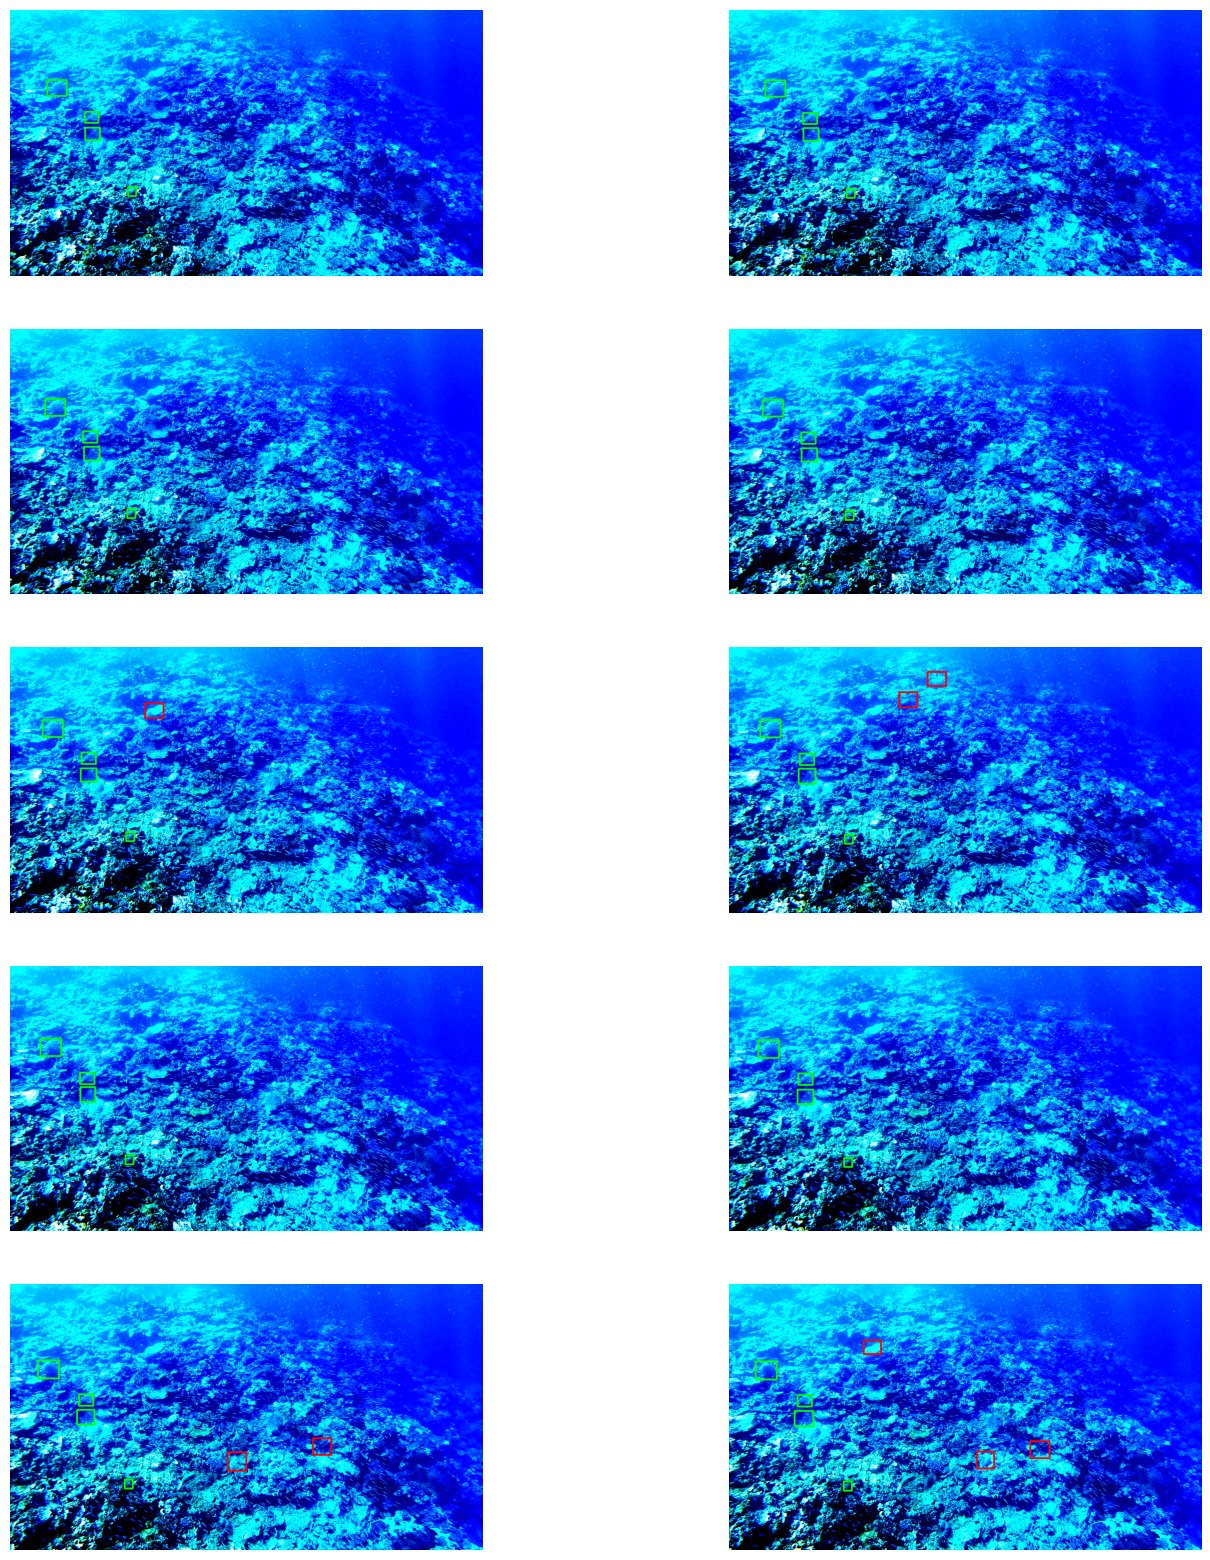

In [33]:
def view_sample(df_sample, model, device):
    ds_val = ReefDataset(df_sample, get_valid_transform())
    dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, collate_fn=collate_fn)

    images, targets, image_ids = next(iter(dl_val))

    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    # [x_center, y_center, width, height] # All scaled
    boxes = targets[0]['boxes'].cpu().numpy()
    # De-scaled
    boxes = np.array([np.array(box).astype(np.int32) for box in boxes*np.array([WIDTH, HEIGHT, WIDTH, HEIGHT], dtype=np.float32)])

    #[x_min, y_min, width, height]
    boxes[:, 0] = boxes[:, 0] - (boxes[:, 2] / 2) # x_center --> x_min
    boxes[:, 1] = boxes[:, 1] - (boxes[:, 3] / 2) # y_center --> y_min

    sample = images[0].permute(1,2,0).cpu().numpy()

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images)

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    # fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    for box in boxes:
        x, y, w, h = box
        cv2.rectangle(sample, (x, y), (x+w, y+h), (0, 220, 0), 3)

    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = np.array([np.array(box).astype(np.int32) for box in oboxes*np.array([WIDTH, HEIGHT, WIDTH, HEIGHT], dtype=np.float32)])

    # [x_min, y_min, width, height]
    oboxes[:, 0] = oboxes[:, 0] - (oboxes[:, 2] / 2) # x_center --> x_min
    oboxes[:, 1] = oboxes[:, 1] - (oboxes[:, 3] / 2) # y_center --> y_min

    prob   = outputs[0]['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]

    scored_boxes = list(zip(oboxes, prob))
    sorted_boxes = list(sorted(scored_boxes, key=lambda y: -y[1]))

    for i, (box, p) in enumerate(sorted_boxes):
        x, y, w, h = box

        if p > 0.5:
            cv2.rectangle(sample, (x, y), (x+w, y+h), (220, 0, 0), 3)

        if i > 18:
            break

    return sample


fig, axes = plt.subplots(5, 2, figsize=(17, 20))
axes = axes.flatten()

df_sample = df_val[df_val['n_annotations'] > 3].iloc[:10]

for i in range(len(df_sample)):
  sample = view_sample(pd.DataFrame(df_sample.iloc[i]).T, model=model,device=torch.device('cuda'))

  axes[i].imshow(sample)
  axes[i].set_axis_off()

plt.show()